In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip3 install neurite
%cd "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration"
!ls

/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration
 affineRegNN2_debug.ipynb	    layers.py
 affineRegNN3_data1_svd_rot.ipynb   model_img
 affineRegNN4_data2.ipynb	    MRNet
 affineRegNN_archive.ipynb	    prototype.py
 affine_training_data_gen.ipynb     __pycache__
 baseline_DLIR_v2.png		    utils.py
 checkpoints			   'VoxelMorph Demo.ipynb'
 data				    VoxelMorphNetworkStructure1.png
 generate_data2.m		    VoxelMorphNetworkStructure2.png


In [3]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random
import math
from tqdm.notebook import tqdm

import layers as custom_layers

In [4]:
# ('2.5.0', '2.5.0')
tf.__version__, keras.__version__

('2.6.0', '2.6.0')

In [ ]:
# MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'
# fixedImg = np.load(MRI_Path.format('0701'))
MRI_Path = "/content/drive/MyDrive/Colab Notebooks/Radiology/MSK-Image-Registration/data/test_data/0701.npy"
fixedImg = np.load(MRI_Path)
fixedImg.shape

(52, 256, 256)

In [ ]:
inputImg = np.expand_dims(fixedImg, axis=-1)
inputImg = inputImg / np.max(inputImg) # normalize
inputImg = np.expand_dims(inputImg, axis=0)
list(inputImg.shape)[1:]

[52, 256, 256, 1]

In [ ]:
# Get rid of the batch dimension
imgInput = keras.Input(shape = list(inputImg.shape)[1:])
affineInput = keras.Input(shape = (12,))

# use a built layer for data transformation as in network prediction
affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, indexing="ij", shift_center=True)([imgInput, affineInput])
print(affine_warped.shape)

Instructions for updating:
Use fn_output_signature instead
(None, 52, 256, 256, 1)


In [ ]:
model = keras.Model(inputs=[imgInput, affineInput], outputs=affine_warped, name="affine_transformation")
model.summary(line_length=150)

Model: "affine_transformation"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 52, 256, 256, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
input_2 (InputLayer)                             [(None, 12)]                     0                                                                   
______________________________________________________________________________________________________________________________________________________
spatial_transformer (SpatialTransformer)         (None, 52, 256

## Generate gt params for affine trans matrix


Shearing transformation matrix

[$h_(ij)$: shear j axis w.r.t. i ](https://forums.sketchup.com/t/3d-shear-notation/56854), or shear in the direction of i ?


![shear](https://aws1.discourse-cdn.com/sketchup/original/3X/f/6/f660d501f621f44622b39bb60f6e0e3ca8359016.JPG)

$\phi$ is the shear angle between the axis and x/y/z
![shear composition](https://miro.medium.com/max/4800/1*NgzDF96DFbIbA5q6n_jjew.png)

<hr>

**Approach 1**: Fixed img to Moving img (extract affine params from inverse transformation matrix)
* Generate training data, output:
    1. affine transformed img
    2. affine trans param, 18 in total: 
        * 3 translation
        * 9 rotation (3x3 mat)
        * 3 scaling
        * 3 skewing (not really skewing)
* Potential problem: 
    * Non-uniqueness of decomposition of 3D affine transformation matrix into translation, scaling, rotation, and shearing.
    * Example of such non-uniqueness: https://math.stackexchange.com/questions/1415854/decompose-affine-transformation-including-shear-in-x-and-y
* One solution (not unique): https://math.stackexchange.com/a/78169
    * Use QR decomposition to extract rotation first (q is orthonormal and r is upper-triangular)
    * **Con**: Assume only shearing in x and y direction (y/z-axis shearing?). Maybe this assumption does not fit our data
    * **Pro**: works for any affine transformation matrix

**Approach 2**: Moving img to Fixed img (directly use the sampled affine params and avoid the inv operation). Moreover, use multiple real images as moving images
* **Pro**: easier to get the affine params
* **Con**: using this approach means that the moving image always looks good (since we always use real images as Moving img), but this situation may not be what we want during testing.

* methods:
  1. baseline: 12 flattened matrix params
  2. separate representation for affine trans param, 21 in total: 
        * 3 translation
        * 9 rotation (3x3 mat)
        * 3 scaling
        * 6 skewing (one-to-one?)

### Approach 1

In [ ]:
## Conversion: Mat param and new representation param
def mat_to_affine_param(mat, debug=False):
    """
    Extract affine parameters from trans
    Args:
        trans: nparray, [4,4]
    Ret:
        affine params [12]:
            trans: 0-3
            rot: 3-12
            scale: 12-15
            shear: 15-18
    """
    # gt_rot = (rotZ @ rotY @ rotX)[:3, :3].flatten()
    # gt_scale = np.diag(scaling)[:3]
    # gt_param = np.concatenate([gt_trans, gt_rot, gt_scale])

    trans = mat[:3, 3]
    rot, upper_triag = np.linalg.qr(mat[:3,:3])
    scale = np.diag(upper_triag)
    shear = upper_triag/scale
    if debug:
        print("mat");display(mat)
        print("translation");display(trans)
        print("rot");display(rot)
        print("scale");display(np.diag(scale))
        print("shear");display(shear)

    shear = [shear[0,1], shear[0,2], shear[1,2]]
    affine_param = np.concatenate([trans, rot.flatten(), scale, shear])
    return affine_param

def affine_param_to_mat(affine_param):
    """
    Construct affine transformation matrix from affine params
    Args:
        affine_param: nparray [18]
    ret:
        mat: [4,4]
    """
    assert len(affine_param) == 18, "affine_param needs to have length 18"
    trans, rot, scale, shear_param = affine_param[0:3], affine_param[3:12], \
                                     affine_param[12:15], affine_param[15:18]
    rot = rot.reshape((3,3))
    scale = np.diag(scale)
    shear = np.eye(3)
    shear[0,1] = shear_param[0]
    shear[0,2] = shear_param[1]
    shear[1,2] = shear_param[2]
    mat = np.eye(4)
    mat[:3,:3] = rot @ shear @ scale
    mat[:3, 3] = trans
    return mat

In [ ]:
## Approach 1
output_data_dir = "data/affineTrainingData_SVD_Rot"
os.makedirs(output_data_dir, exist_ok=True)
for i in tqdm(range(2000)):
# for i in tqdm(range(500)):
    # transformedImg = np.zeros(fixedImg.shape)

    translation = np.eye(4)
    rotX = np.eye(4)
    rotY = np.eye(4)
    rotZ = np.eye(4)
    scaling = np.eye(4)

    # translation
    xTranslationRange = 5
    yTranslationRange = 30
    zTranslationRange = 30
    translation[0, 3] = xTranslationRange * random.random()
    translation[1, 3] = yTranslationRange * random.random()
    translation[2, 3] = zTranslationRange * random.random()

    # rotation
    xRotAngle = math.pi / random.uniform(8, 80)
    rotX[1, 1] = math.cos(xRotAngle)
    rotX[1, 2] = math.sin(xRotAngle)
    rotX[2, 1] = -math.sin(xRotAngle)
    rotX[2, 2] = math.cos(xRotAngle)

    yRotAngle = math.pi / random.uniform(40, 160)
    rotY[0, 0] = math.cos(yRotAngle)
    rotY[0, 2] = -math.sin(yRotAngle)
    rotY[2, 0] = math.sin(yRotAngle)
    rotY[2, 2] = math.cos(yRotAngle)

    zRotAngle = math.pi / random.uniform(40, 160)
    rotZ[0, 0] = math.cos(zRotAngle)
    rotZ[0, 1] = -math.sin(zRotAngle)
    rotZ[1, 0] = math.sin(zRotAngle)
    rotZ[1, 1] = math.cos(zRotAngle)

    scalingX = random.uniform(0.85, 1.15)
    scalingY = random.uniform(0.85, 1.15)
    scalingZ = random.uniform(0.85, 1.15)
    scaling[0, 0] = scalingX
    scaling[1, 1] = scalingY
    scaling[2, 2] = scalingZ

    transMat = translation @ rotZ @ rotY @ rotX @ scaling
    affine_param = transMat[0:3].flatten()
    affine_param = np.expand_dims(affine_param, axis=0)
    
    transformedImg = model([inputImg, affine_param])
    transformedImg = tf.squeeze(transformedImg)

    # gt affine trans params
    transMat_inv = np.linalg.inv(transMat)
    # trf_to_save = transMat_inv[0:3].flatten()
    trf_to_save = mat_to_affine_param(transMat_inv)
    
    path = os.path.join(output_data_dir, "affine{}.npz")
    f = open(path.format(i), "wb")
    np.savez(f, img = transformedImg, trf = trf_to_save)
    f.close()
    if (i % 100 == 0):
        print("Milestone: file {} has been saved.".format(i))

  0%|          | 0/2000 [00:00<?, ?it/s]

Milestone: file 0 has been saved.
Milestone: file 100 has been saved.
Milestone: file 200 has been saved.
Milestone: file 300 has been saved.
Milestone: file 400 has been saved.
Milestone: file 500 has been saved.
Milestone: file 600 has been saved.
Milestone: file 700 has been saved.
Milestone: file 800 has been saved.
Milestone: file 900 has been saved.
Milestone: file 1000 has been saved.
Milestone: file 1100 has been saved.
Milestone: file 1200 has been saved.
Milestone: file 1300 has been saved.
Milestone: file 1400 has been saved.
Milestone: file 1500 has been saved.
Milestone: file 1600 has been saved.
Milestone: file 1700 has been saved.
Milestone: file 1800 has been saved.
Milestone: file 1900 has been saved.


### Approach 2, v3

* from Moving img get transformed fixed img
* use multiple real img as moving img
  * Use all axial data from MRNet dataset, following their split: `MRNet-v1.0/train/axial` as train_data_dir, `MRNet-v1.0/valid/axial` as test_data_dir
  * 1000 real images as moving image
  * 5 random transformation is applied to each moving image to form 5 pairs of Fixed-Moving image, 5000 pairs in total
  * 130 real img * 5 = 650 validation pairs
  * 120 real img * 5 = 600 test pairs
* fixed_depth = 64, (assuming the max #slices ≤ 64)
* max shearing angle for all axes is 3°
* use threshold of 0.1 to filter out noisy background
* change the outermost layer to zero to avoid the mess when extrapolating with the nearest neighbor
* include new affine representation with 21 params:
    * trans: [0-3)
    * rot: [3-12)
    * shear: [12-18)
    * scale: [18-21)


In [5]:
train_data_dir = "./data/train_axial"
test_data_dir = "./data/test_axial"
train_val_split = 1000 # train [0:1000], val [1000:]

In [6]:
## Load data paths
def extract_img_list(data_dir):
    source_img_list = []
    for data_path in os.listdir(data_dir):
        if data_path.endswith(".npy"):
            source_img_list.append(os.path.join(data_dir, data_path))
    return source_img_list

train_img_list = extract_img_list(train_data_dir)
val_img_list = train_img_list[train_val_split:]
train_img_list = train_img_list[0: train_val_split]
test_img_list = extract_img_list(test_data_dir)

print(len(train_img_list))
print(len(val_img_list))
print(len(test_img_list))

# # print max depth: 61
# max_depth = 0
# for path in train_img_list:
#     M = np.load(path)
#     # print(M.shape)
#     if len(M) > max_depth:
#         max_depth = len(M)
# print(max_depth)

1000
130
120


In [7]:
## Approach 2 hyperparameter
output_train_data_dir = "data/affineTrainingData3/train"
output_val_data_dir = "data/affineTrainingData3/val"
output_test_data_dir = "data/affineTrainingData3/test"

threshold = 0.1 # for filtering background noise
fixed_depth = 64

num_for_each = 5 # num of transformation/generated samples from each real img # 300
save_21param = True # new representation for affine params

In [8]:
## generate pairs of transformed images and real/moving img
def generate_img_pair_and_trf(source_img_list, output_dir, num_for_each):
    os.makedirs(output_dir, exist_ok=True)
    for i, MRI_Path in tqdm(enumerate(source_img_list), total=len(source_img_list)):
        movingImg = np.load(MRI_Path)
        inputImg = np.expand_dims(movingImg, axis=-1)
        inputImg = inputImg / np.max(inputImg) # normalize
        inputImg = np.expand_dims(inputImg, axis=0)
        
        # filter noisy background
        inputImg[inputImg < threshold] = 0
        # change the outermost layer to zero
        inputImg = inputImg[:,:,1:-1, 1:-1, :]
        inputImg = np.pad(inputImg, pad_width=((0,0),(0,0),(1,1),(1,1),(0,0)), mode="constant",
                        constant_values=0)
        # pad depth with 0
        depth = inputImg.shape[1]
        up_pad = (fixed_depth-depth)//2
        down_pad = fixed_depth - depth - up_pad
        if inputImg.shape[1] == 64:
            nputImg = inputImg[:,1:-1, :,:, :]
            up_pad = 1
            down_pad = 1
        inputImg = np.pad(inputImg, pad_width=((0,0),(up_pad,down_pad),(0,0),(0,0),(0,0)), 
                            mode="constant", constant_values=0)
        # print(list(inputImg.shape))

        # use a built layer for data transformation as in network prediction
        imgInput = keras.Input(shape = list(inputImg.shape)[1:]) # Get rid of the batch dimension
        affineInput = keras.Input(shape = (12,))
        affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, indexing="ij", shift_center=True)([imgInput, affineInput])
        model = keras.Model(inputs=[imgInput, affineInput], outputs=affine_warped, name="affine_transformation")

        # Transform img
        for j in range(num_for_each):
            translation = np.eye(4)
            rotX = np.eye(4)
            rotY = np.eye(4)
            rotZ = np.eye(4)
            scaling = np.eye(4)

            # translation
            xTranslationRange = 5
            yTranslationRange = 30
            zTranslationRange = 0#30
            translation[0, 3] = xTranslationRange * random.random()
            translation[1, 3] = yTranslationRange * random.random()
            translation[2, 3] = zTranslationRange * random.random()

            # rotation
            xRotAngle = math.pi / random.uniform(8, 80)
            rotX[1, 1] = math.cos(xRotAngle)
            rotX[1, 2] = math.sin(xRotAngle)
            rotX[2, 1] = -math.sin(xRotAngle)
            rotX[2, 2] = math.cos(xRotAngle)

            yRotAngle = math.pi / random.uniform(40, 160)
            rotY[0, 0] = math.cos(yRotAngle)
            rotY[0, 2] = -math.sin(yRotAngle)
            rotY[2, 0] = math.sin(yRotAngle)
            rotY[2, 2] = math.cos(yRotAngle)

            zRotAngle = math.pi / random.uniform(40, 160)
            rotZ[0, 0] = math.cos(zRotAngle)
            rotZ[0, 1] = -math.sin(zRotAngle)
            rotZ[1, 0] = math.sin(zRotAngle)
            rotZ[1, 1] = math.cos(zRotAngle)

            scalingX = random.uniform(0.85, 1.15)
            scalingY = random.uniform(0.85, 1.15)
            scalingZ = random.uniform(0.85, 1.15)
            scaling[0, 0] = scalingX
            scaling[1, 1] = scalingY
            scaling[2, 2] = scalingZ

            # shearing
            shear_lower_limit = 0
            shear_upper_limit = 3/180 * np.pi
            shearXY = random.uniform(shear_lower_limit, shear_upper_limit)
            shearXZ = random.uniform(shear_lower_limit, shear_upper_limit)
            shearYX = random.uniform(shear_lower_limit, shear_upper_limit)
            shearYZ = random.uniform(shear_lower_limit, shear_upper_limit)
            shearZX = random.uniform(shear_lower_limit, shear_upper_limit)
            shearZY = random.uniform(shear_lower_limit, shear_upper_limit)
            # get the shearing matrix on x axis (wrt. x)
            shearX_M = np.array([[      1, 0, 0, 0],
                                [np.tan(shearYX), 1, 0, 0],
                                [np.tan(shearZX), 0, 1, 0],
                                [      0, 0, 0, 1]])
            # get the shearing matrix on y axis
            shearY_M = np.array([[1, np.tan(shearXY), 0, 0],
                                [0,       1, 0, 0],
                                [0, np.tan(shearZY), 1, 0],
                                [0,       0, 0, 1]])
            # get the shearing matrix on z axis
            shearZ_M = np.array([[1, 0, np.tan(shearXZ), 0],
                            [0, 1, np.tan(shearYZ), 0],
                            [0, 0,       1, 0],
                            [0, 0,       0, 1]])
            shearing = shearX_M @ shearY_M @ shearZ_M

            transMat = translation @ rotZ @ rotY @ rotX @ shearing @ scaling # shearing before rot since it makes more sence to shear wrt. the matched axes
            affine_param = transMat[0:3].flatten()[np.newaxis, :]
            # affine_param = np.expand_dims(affine_param, axis=0)
            fixed_img = model([inputImg, affine_param])
            if save_21param: 
                affine_21_params = np.concatenate([ # order: trans, rot, shear, scale
                    transMat[0:3, 3],
                    (rotZ @ rotY @ rotX)[:3,:3].flatten(),
                    [np.tan(shearYX), np.tan(shearZX), np.tan(shearXY), np.tan(shearZY), np.tan(shearXZ), np.tan(shearYZ)],
                    [scalingX, scalingY, scalingZ]
                ])
                affine_21_params = affine_21_params[np.newaxis, :]
            
            path = os.path.join(output_dir, f"affine_{i}_{j}.npz")
            with open(path, "wb") as f:
                if save_21param:
                    np.savez(f, fixedImg=fixed_img, movingImg=inputImg, 
                            trf=affine_param, trf_21param=affine_21_params)
                else:
                    np.savez(f, fixedImg=fixed_img, movingImg=inputImg, 
                            trf=affine_param)

In [ ]:
generate_img_pair_and_trf(train_img_list, output_dir=output_train_data_dir, num_for_each=num_for_each)
generate_img_pair_and_trf(val_img_list, output_dir=output_val_data_dir, num_for_each=num_for_each)
generate_img_pair_and_trf(test_img_list, output_dir=output_test_data_dir, num_for_each=num_for_each)

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead


### Testing mat_to_affine_param & affine_param_to_mat

In [ ]:
translation = np.eye(4)
rotX = np.eye(4)
rotY = np.eye(4)
rotZ = np.eye(4)
scaling = np.eye(4)

# translation
xTranslationRange = 5
yTranslationRange = 30
zTranslationRange = 30
translation[0, 3] = xTranslationRange * random.random()
translation[1, 3] = yTranslationRange * random.random()
translation[2, 3] = zTranslationRange * random.random()

# rotation
xRotAngle = math.pi / random.uniform(8, 80)
rotX[1, 1] = math.cos(xRotAngle)
rotX[1, 2] = math.sin(xRotAngle)
rotX[2, 1] = -math.sin(xRotAngle)
rotX[2, 2] = math.cos(xRotAngle)

yRotAngle = math.pi / random.uniform(40, 160)
rotY[0, 0] = math.cos(yRotAngle)
rotY[0, 2] = -math.sin(yRotAngle)
rotY[2, 0] = math.sin(yRotAngle)
rotY[2, 2] = math.cos(yRotAngle)

zRotAngle = math.pi / random.uniform(40, 160)
rotZ[0, 0] = math.cos(zRotAngle)
rotZ[0, 1] = -math.sin(zRotAngle)
rotZ[1, 0] = math.sin(zRotAngle)
rotZ[1, 1] = math.cos(zRotAngle)

scalingX = random.uniform(0.85, 1.15)
scalingY = random.uniform(0.85, 1.15)
scalingZ = random.uniform(0.85, 1.15)
scaling[0, 0] = scalingX
scaling[1, 1] = scalingY
scaling[2, 2] = scalingZ

transMat = translation @ rotZ @ rotY @ rotX @ scaling
affine_param = transMat[0:3].flatten()
affine_param = np.expand_dims(affine_param, axis=0)

transformedImg = model([inputImg, affine_param])
transformedImg = tf.squeeze(transformedImg)

transMat_inv = np.linalg.inv(transMat)
display(transMat)
display(transMat_inv)

array([[ 0.88960318, -0.02451633, -0.03080997,  1.77154832],
       [ 0.0240112 ,  1.00774059,  0.07717959, 19.73801556],
       [ 0.02787193, -0.08565084,  0.91688945, 15.05562097],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

array([[  1.12217764,   0.0302886 ,   0.03515866,  -3.11516408],
       [ -0.02395394,   0.98462339,  -0.08368605, -18.13213085],
       [ -0.03634999,   0.09105746,   1.08175776, -18.01943264],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [ ]:
affine_param = mat_to_affine_param(transMat_inv, debug=True)
print()
new_mat = affine_param_to_mat(affine_param)
display(transMat_inv)
display(new_mat)
np.allclose(transMat_inv, new_mat)

mat


array([[  1.12217764,   0.0302886 ,   0.03515866,  -3.11516408],
       [ -0.02395394,   0.98462339,  -0.08368605, -18.13213085],
       [ -0.03634999,   0.09105746,   1.08175776, -18.01943264],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

translation


array([ -3.11516408, -18.13213085, -18.01943264])

rot


array([[-0.99924839, -0.02423687,  0.03025273],
       [ 0.0213299 , -0.99544069, -0.09296708],
       [ 0.03236803, -0.09225191,  0.99520947]])

scale


array([[-1.12302171,  0.        ,  0.        ],
       [ 0.        , -0.98926851,  0.        ],
       [ 0.        ,  0.        ,  1.08541927]])

shear


array([[ 1.        ,  0.00638509, -0.00175313],
       [-0.        ,  1.        , -0.01597711],
       [-0.        , -0.        ,  1.        ]])

array([[  1.12217764,   0.0302886 ,   0.03515866,  -3.11516408],
       [ -0.02395394,   0.98462339,  -0.08368605, -18.13213085],
       [ -0.03634999,   0.09105746,   1.08175776, -18.01943264],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

array([[  1.12217764,   0.0302886 ,   0.03515866,  -3.11516408],
       [ -0.02395394,   0.98462339,  -0.08368605, -18.13213085],
       [ -0.03634999,   0.09105746,   1.08175776, -18.01943264],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

True

## Check generated training dataset

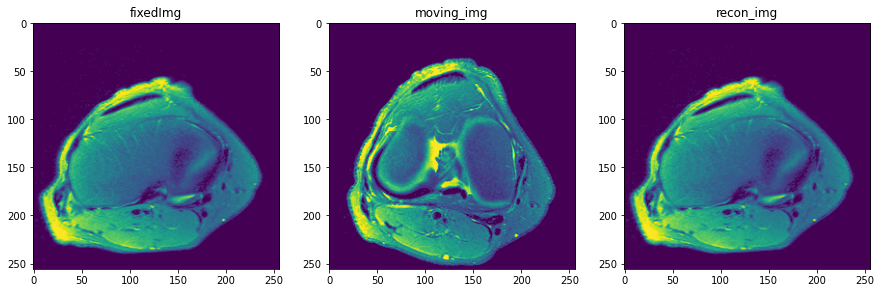

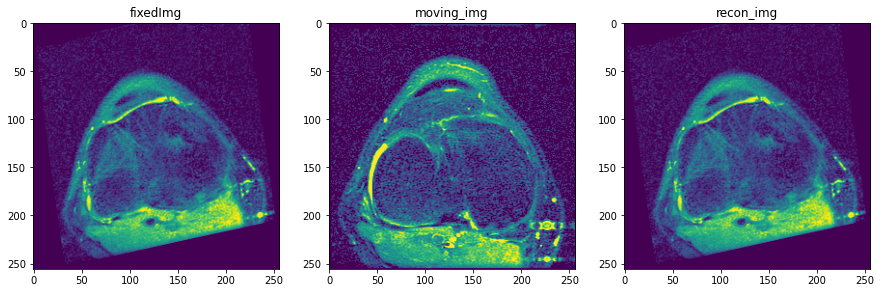

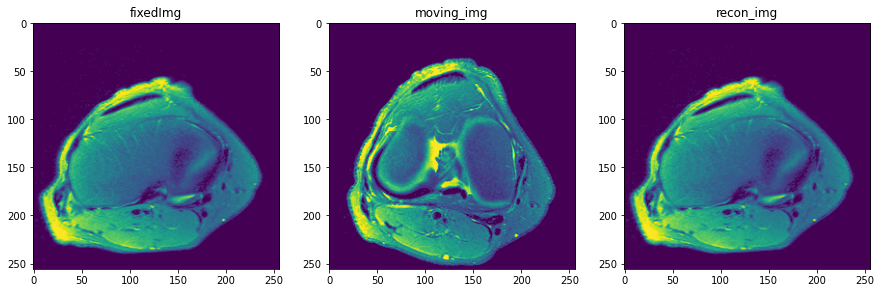

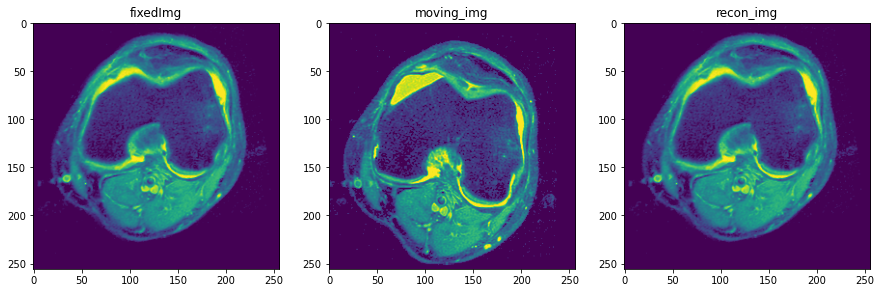

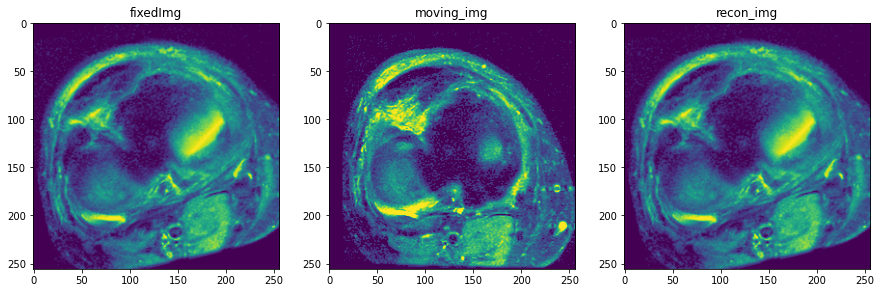

In [33]:
## Visualization
## affine_param_format:
    # None: normal affine mat, 
    # qr_decomp_SVD_rot: approach 1 & 18 param, 
    # "affine_21_param": approach 2 & 21 param

affine_param_format = "affine_21_param"
trainDataPath = "./data/affineTrainingData3/test/affine_{}_0.npz"
num_check = 5
max_num = 10

for _ in range(num_check):
    sample_idx = random.randrange(max_num)
    zip_obj = np.load(trainDataPath.format(sample_idx))
    # moving_img = zip_obj['img']
    fixedImg = zip_obj["fixedImg"]
    moving_img = zip_obj["movingImg"]
    # moving_img = np.expand_dims(moving_img, axis = -1)
    # moving_img = np.expand_dims(moving_img, axis = 0)
    target_trf = zip_obj['trf']
    if affine_param_format == "qr_decomp_SVD_rot":
        target_trf = affine_param_to_mat(target_trf)[:3].flatten()
    elif affine_param_format == "affine_21_param":
        target_trf = zip_obj['trf_21param'][0]
        trans, rot, shear, scale = target_trf[0:3],target_trf[3:12],target_trf[12:18], target_trf[18:21]
        trans = trans.reshape((-1,1))
        rot_M = rot.reshape((3,3))
        shearX_M = np.array([[      1, 0, 0],
                            [shear[0], 1, 0],
                            [shear[1], 0, 1]])
        # get the shearing matrix on y axis
        shearY_M = np.array([[1, shear[2], 0],
                            [0,       1, 0],
                            [0, shear[3], 1]])
        # get the shearing matrix on z axis
        shearZ_M = np.array([[1, 0, shear[4]],
                             [0, 1, shear[5]],
                             [0, 0,       1 ]])
        scale_M = np.diag(scale)
        affine_mat = rot_M @ shearX_M @ shearY_M @ shearZ_M @ scale_M
        affine_mat = np.concatenate([affine_mat, trans], axis=-1)
        target_trf = affine_mat.flatten()
    # target_trf = np.expand_dims(target_trf, axis = 0)

    # use a built layer for data transformation as in network prediction
    imgInput = keras.Input(shape = list(fixedImg.shape)[1:]) # Get rid of the batch dimension
    affineInput = keras.Input(shape = (12,))
    affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, indexing="ij", shift_center=True)([imgInput, affineInput])
    model = keras.Model(inputs=[imgInput, affineInput], outputs=affine_warped, name="affine_transformation")
    recon_img = model([moving_img, target_trf])

    fixedImg = np.squeeze(fixedImg)
    moving_img = np.squeeze(moving_img)
    recon_img = np.squeeze(recon_img)
    sliceToCheck = 35
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(fixedImg[sliceToCheck, :, :])
    axs[0].set_title("fixedImg")
    axs[1].imshow(moving_img[sliceToCheck, :, :])
    axs[1].set_title("moving_img")
    axs[2].imshow(recon_img[sliceToCheck, :, :])
    axs[2].set_title("recon_img")
    plt.show()

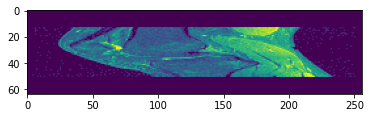

In [ ]:
plt.imshow(moving_img[:,:,128])

## Threshold for background

In [ ]:
# print(np.unique(moving_img, return_counts=True)[0][:30])
# print(np.unique(moving_img, return_counts=True)[1][:30])
display(dict(zip(np.unique(moving_img, return_counts=True)[0][:50], 
               np.unique(moving_img, return_counts=True)[1][:50]))
)
print()
print(moving_img[sliceToCheck, 3,3])
print(moving_img[sliceToCheck, 50,50])

{0.0: 104998,
 0.00392156862745098: 5412,
 0.00784313725490196: 9925,
 0.011764705882352941: 9224,
 0.01568627450980392: 6626,
 0.0196078431372549: 6237,
 0.023529411764705882: 9958,
 0.027450980392156862: 19987,
 0.03137254901960784: 38359,
 0.03529411764705882: 61803,
 0.0392156862745098: 84380,
 0.043137254901960784: 98683,
 0.047058823529411764: 100474,
 0.050980392156862744: 96120,
 0.054901960784313725: 83941,
 0.058823529411764705: 71579,
 0.06274509803921569: 56593,
 0.06666666666666667: 46181,
 0.07058823529411765: 35574,
 0.07450980392156863: 29920,
 0.0784313725490196: 24374,
 0.08235294117647059: 20344,
 0.08627450980392157: 17571,
 0.09019607843137255: 16278,
 0.09411764705882353: 14437,
 0.09803921568627451: 13795,
 0.10196078431372549: 13039,
 0.10588235294117647: 12336,
 0.10980392156862745: 11527,
 0.11372549019607843: 11295,
 0.11764705882352941: 10117,
 0.12156862745098039: 9583,
 0.12549019607843137: 9136,
 0.12941176470588237: 8318,
 0.13333333333333333: 7942,
 0.1


0.0
0.050980392156862744


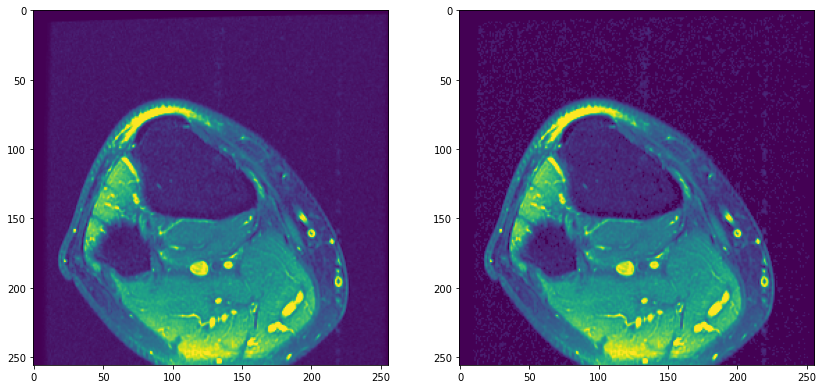

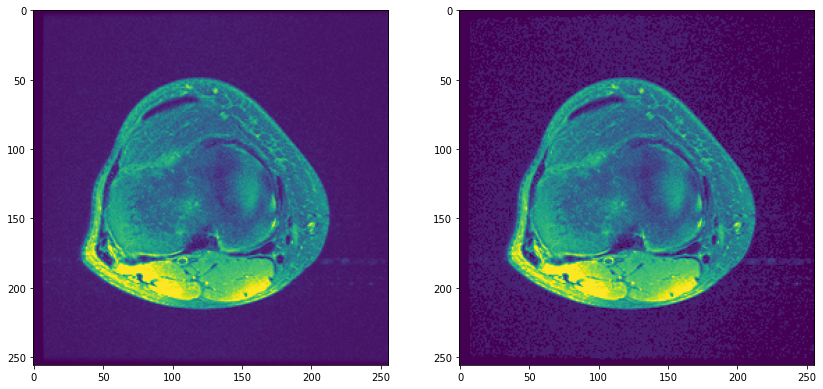

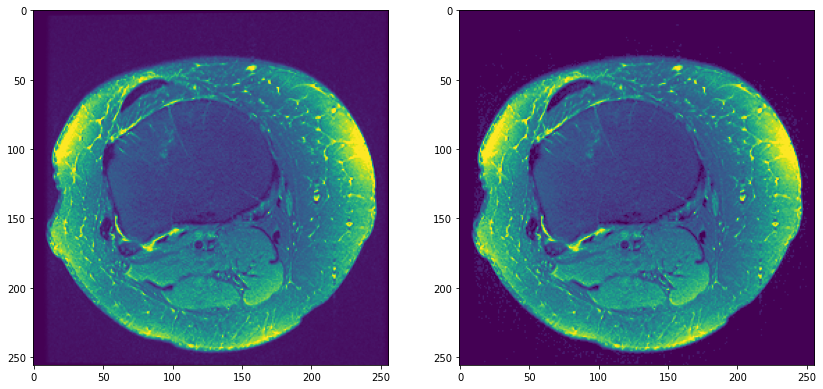

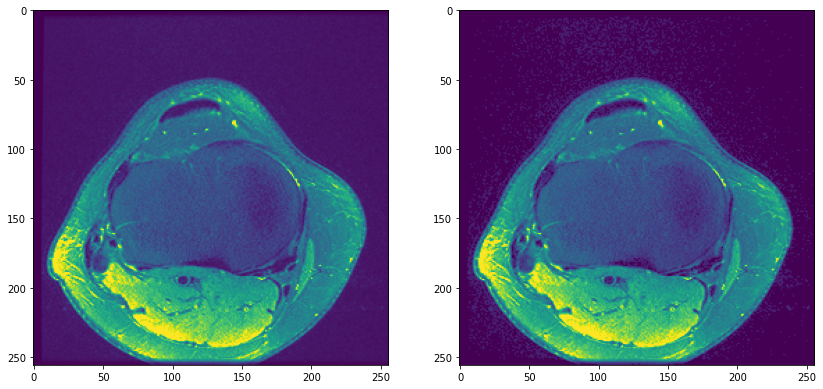

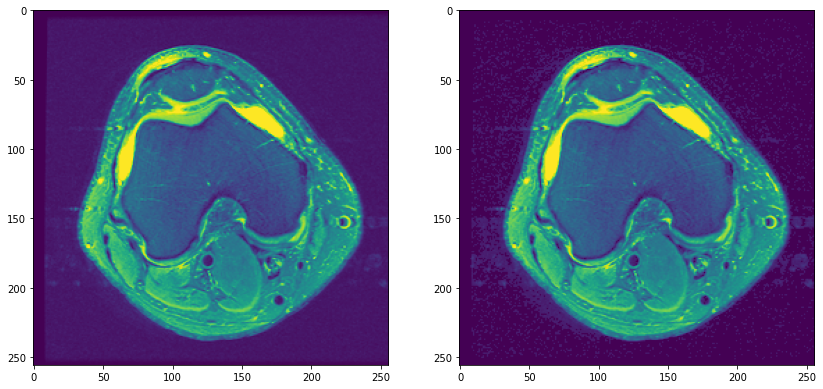

In [ ]:
# compare original img V.S. filtered img
source_img_list = [
    "data/test_data/0001.npy",
    "data/test_data/0002.npy",
    "data/test_data/0003.npy",
    "data/test_data/0004.npy",
    "data/test_data/0701.npy",
]

# print depth
for path in source_img_list:
    moving_img = np.load(path)
    moving_img = moving_img / np.max(moving_img) # normalize

    fig, axes = plt.subplots(1,2, figsize=(14,7))
    axes[0].imshow(moving_img[sliceToCheck])

    threshold = 0.1 #
    filtered_img = moving_img.copy()
    filtered_img[filtered_img < threshold] = 0
    axes[1].imshow(filtered_img[sliceToCheck])
    plt.show()

In [ ]:
x,y = 50, 50
moving_img[sliceToCheck, x, y], filtered_img[sliceToCheck, x, y]

(0.050980392156862744, 0.050980392156862744)

## For testing purposes: check random transformed image samples

In [ ]:
transformedImg = np.zeros(fixedImg.shape)

translation = np.eye(4)
rotX = np.eye(4)
rotY = np.eye(4)
rotZ = np.eye(4)
scaling = np.eye(4)

xTranslationRange = 5
yTranslationRange = 30
zTranslationRange = 30
translation[0, 3] = xTranslationRange * random.random()
translation[1, 3] = yTranslationRange * random.random()
translation[2, 3] = zTranslationRange * random.random()

xRotAngle = math.pi / random.uniform(8, 80)
rotX[1, 1] = math.cos(xRotAngle)
rotX[1, 2] = math.sin(xRotAngle)
rotX[2, 1] = -math.sin(xRotAngle)
rotX[2, 2] = math.cos(xRotAngle)

yRotAngle = math.pi / random.uniform(40, 160)
rotY[0, 0] = math.cos(yRotAngle)
rotY[0, 2] = -math.sin(yRotAngle)
rotY[2, 0] = math.sin(yRotAngle)
rotY[2, 2] = math.cos(yRotAngle)

zRotAngle = math.pi / random.uniform(40, 160)
rotZ[0, 0] = math.cos(zRotAngle)
rotZ[0, 1] = -math.sin(zRotAngle)
rotZ[1, 0] = math.sin(zRotAngle)
rotZ[1, 1] = math.cos(zRotAngle)

scalingX = random.uniform(0.85, 1.15)
scalingY = random.uniform(0.85, 1.15)
scalingZ = random.uniform(0.85, 1.15)
scaling[0, 0] = scalingX
scaling[1, 1] = scalingY
scaling[2, 2] = scalingZ

transMat = translation @ rotZ @ rotY @ rotX @ scaling

affine_param_test = transMat[0:3].flatten()
affine_param_test = np.expand_dims(affine_param_test, axis=0)

transformedImg = model([inputImg, affine_param_test])
transformedImg = tf.squeeze(transformedImg)

In [ ]:
sliceToCheck_x = 25
sliceToCheck_y = 100
sliceToCheck_z = 100
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs[0, 0].imshow(fixedImg[sliceToCheck_x, :, :])
axs[0, 1].imshow(transformedImg[sliceToCheck_x, :, :])
axs[1, 0].imshow(fixedImg[:, sliceToCheck_y, :])
axs[1, 1].imshow(transformedImg[:, sliceToCheck_y, :])
axs[2, 0].imshow(fixedImg[:, :, sliceToCheck_z])
axs[2, 1].imshow(transformedImg[:, :, sliceToCheck_z])